In [1]:
import tensorflow as tf

import tensorflow_docs as docs
import tensorflow_docs.plots

import matplotlib.pyplot as plt

In [2]:
image_path = tf.keras.utils.get_file("cat.jpg", "https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg")

24576/17858 [=========================================] - 0s 0us/step


In [5]:
image_string = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image_string, channels=3)

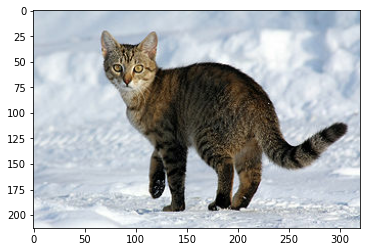

In [8]:
plt.imshow(image)

## Augment a single image

### Flipping the image

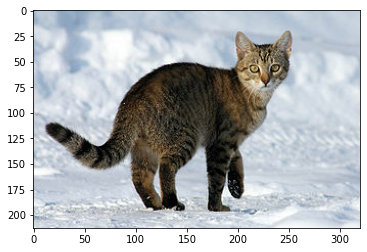

In [10]:
flipped = tf.image.flip_left_right(image)
plt.imshow(flipped)

### Grayscale the image

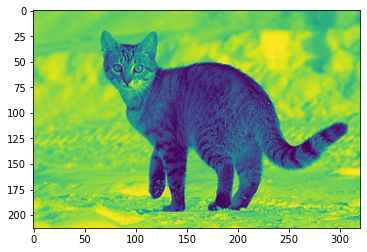

In [14]:
grayscaled = tf.image.rgb_to_grayscale(image)
plt.imshow(tf.squeeze(grayscaled, axis=-1))

### Saturate the image

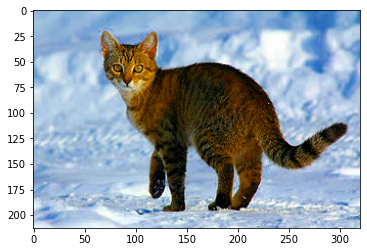

In [15]:
saturated = tf.image.adjust_saturation(image, 3)
plt.imshow(saturated)

### Change image brightness

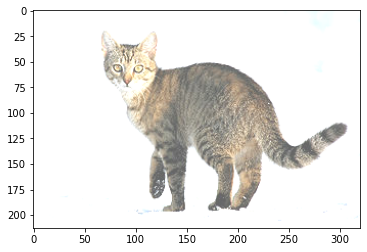

In [16]:
bright = tf.image.adjust_brightness(image, 0.4)
plt.imshow(bright)

### Rotate the image

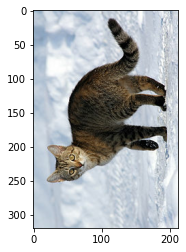

In [17]:
rotated = tf.image.rot90(image)
plt.imshow(rotated)

### Center crop the image

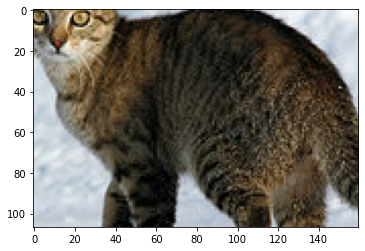

In [18]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
plt.imshow(cropped)

## Augment a dataset and train a model with it

In [2]:
import tensorflow_datasets as tfds

In [3]:
dataset, info =  tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples= info.splits['train'].num_examples

In [4]:
def convert(image, label):
    # Cast and normalize the image to [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label
    
def augment(image, label):
    image, label = convert(image, label)
    # Add 6 pixels of padding, (original is 28 x 28)
    image = tf.image.resize_with_crop_or_pad(image, 34, 34)
    # Random crop back to 28 x 28
    image = tf.image.random_crop(image, size=[28, 28, 1])
    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.5)
    
    return image, label

In [5]:
# Gloabl setting
BATCH_SIZE = 64
NUM_EXAMPLES = 2048

In [6]:
augmented_train_batches = (
    train_dataset
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [14]:
no_augmented_train_batches = (
    train_dataset
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    .map(convert, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [18]:
validation_batches = (
    test_dataset
    .map(convert, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(2 * BATCH_SIZE)
)

In [22]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28, 1]),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dense(10)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return model

In [23]:
model_without_aug = create_model()
model_without_aug.fit(
    no_augmented_train_batches,
    epochs=50,
    validation_data=validation_batches)

Epoch 1/50
32/32 [==============================] - 2s 54ms/step - loss: 0.7635 - accuracy: 0.7646 - val_loss: 0.3335 - val_accuracy: 0.8969
Epoch 2/50
32/32 [==============================] - 1s 43ms/step - loss: 0.1464 - accuracy: 0.9585 - val_loss: 0.3480 - val_accuracy: 0.8992
Epoch 3/50
32/32 [==============================] - 1s 41ms/step - loss: 0.0787 - accuracy: 0.9717 - val_loss: 0.3487 - val_accuracy: 0.9138
Epoch 4/50
32/32 [==============================] - 1s 40ms/step - loss: 0.0487 - accuracy: 0.9814 - val_loss: 0.3198 - val_accuracy: 0.9201
Epoch 5/50
32/32 [==============================] - 1s 39ms/step - loss: 0.0393 - accuracy: 0.9863 - val_loss: 0.3842 - val_accuracy: 0.9130
Epoch 6/50
32/32 [==============================] - 1s 39ms/step - loss: 0.0449 - accuracy: 0.9873 - val_loss: 0.3384 - val_accuracy: 0.9202
Epoch 7/50
32/32 [==============================] - 1s 40ms/step - loss: 0.0331 - accuracy: 0.9873 - val_loss: 0.3653 - val_accuracy: 0.9204
Epoch 8/50
32

In [24]:
model_with_aug = create_model()
model_with_aug.fit(augmented_train_batches, epochs=50, validation_data=validation_batches)

Epoch 1/50
32/32 [==============================] - 1s 43ms/step - loss: 2.2957 - accuracy: 0.3145 - val_loss: 1.1151 - val_accuracy: 0.7042
Epoch 2/50
32/32 [==============================] - 1s 39ms/step - loss: 1.3981 - accuracy: 0.5312 - val_loss: 0.7948 - val_accuracy: 0.7585
Epoch 3/50
32/32 [==============================] - 1s 39ms/step - loss: 1.0274 - accuracy: 0.6558 - val_loss: 0.5187 - val_accuracy: 0.8566
Epoch 4/50
32/32 [==============================] - 1s 42ms/step - loss: 0.8094 - accuracy: 0.7344 - val_loss: 0.4303 - val_accuracy: 0.8838
Epoch 5/50
32/32 [==============================] - 1s 40ms/step - loss: 0.6868 - accuracy: 0.7749 - val_loss: 0.3480 - val_accuracy: 0.8964
Epoch 6/50
32/32 [==============================] - 1s 42ms/step - loss: 0.5784 - accuracy: 0.8159 - val_loss: 0.2837 - val_accuracy: 0.9119
Epoch 7/50
32/32 [==============================] - 1s 41ms/step - loss: 0.5698 - accuracy: 0.8193 - val_loss: 0.2558 - val_accuracy: 0.9239
Epoch 8/50
32

## Conclusion

(0.75, 1.0)

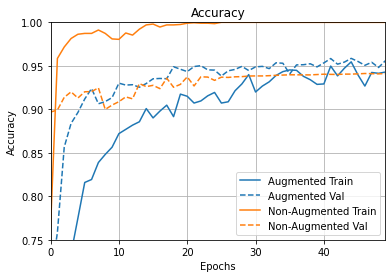

In [28]:
plotter = docs.plots.HistoryPlotter()
plotter.plot({'Augmented': model_with_aug.history, 'Non-Augmented': model_without_aug.history}, metric='accuracy')

plt.title('Accuracy')
plt.ylim([0.75, 1])

(0.0, 1.0)

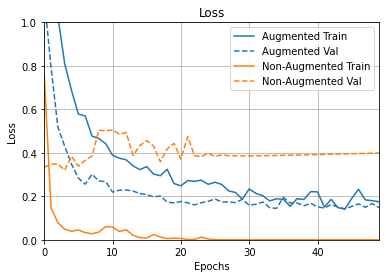

In [29]:
plotter.plot({'Augmented': model_with_aug.history, 'Non-Augmented': model_without_aug.history}, metric='loss')
plt.title('Loss')
plt.ylim([0, 1])